## Import libraries

In [20]:
import pandas as pd
import bambi as bmb
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Load and prepare data

In [21]:
df = pd.read_csv('/Users/georgepaul/Desktop/Research-Project/Data/Data_Ready_Model.csv')
features = [
    'EUI_kWh_per_sqmt', 'SQMT', 'NFLOOR', 'FLCEILHT',
    'MONUSE', 'OCCUPYP', 'WKHRS', 'NWKER',
    'HEATP', 'COOLP', 'DAYLTP', 'HDD65', 'CDD65',
    'YRCONC', 'PUBCLIM'
]
df_model = df[features].dropna()

# Scale numeric features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(df_model.drop(columns=['EUI_kWh_per_sqmt', 'YRCONC', 'PUBCLIM'])),
    columns=[col for col in df_model.columns if col not in ['EUI_kWh_per_sqmt', 'YRCONC', 'PUBCLIM']]
)
df_ready = pd.concat([X_scaled, df_model[['EUI_kWh_per_sqmt', 'YRCONC', 'PUBCLIM']].reset_index(drop=True)], axis=1)

# Make group variables categorical
df_ready['YRCONC'] = df_ready['YRCONC'].astype("category")
df_ready['PUBCLIM'] = df_ready['PUBCLIM'].astype("category")

## Three Models

In [22]:
# --- Model 1: Add random intercepts by YRCONC + PUBCLIM ---
formula1 = 'EUI_kWh_per_sqmt ~ SQMT + NFLOOR + FLCEILHT + MONUSE + OCCUPYP + WKHRS + NWKER + HEATP + COOLP + DAYLTP + HDD65 + CDD65 + (1|YRCONC) + (1|PUBCLIM)'
model1 = bmb.Model(formula=formula1, data=df_ready, family='gaussian')
idata1 = model1.fit(draws=1000, tune=1000, target_accept=0.95, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

# --- Model 2: Add interactions ---
formula2 = 'EUI_kWh_per_sqmt ~ SQMT + HEATP + SQMT:HEATP + NWKER + FLCEILHT + NWKER:FLCEILHT + HDD65 + CDD65 + (1|YRCONC) + (1|PUBCLIM)'
model2 = bmb.Model(formula=formula2, data=df_ready, family='gaussian')
idata2 = model2.fit(draws=1000, tune=1000, target_accept=0.95, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

# --- Model 3: Crossed groups (nested-like) ---
formula3 = 'EUI_kWh_per_sqmt ~ SQMT + FLCEILHT + MONUSE + OCCUPYP + NWKER + HEATP + COOLP + HDD65 + CDD65 + (1|YRCONC:PUBCLIM)'
model3 = bmb.Model(formula=formula3, data=df_ready, family='gaussian')
idata3 = model3.fit(draws=1000, tune=1000, target_accept=0.95, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, SQMT, NFLOOR, FLCEILHT, MONUSE, OCCUPYP, WKHRS, NWKER, HEATP, COOLP, DAYLTP, HDD65, CDD65, 1|YRCONC_sigma, 1|YRCONC_offset, 1|PUBCLIM_sigma, 1|PUBCLIM_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, SQMT, HEATP, SQMT:HEATP, NWKER, FLCEILHT, NWKER:FLCEILHT, HDD65, CDD65, 1|YRCONC_sigma, 1|YRCONC_offset, 1|PUBCLIM_sigma, 1|PUBCLIM_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, SQMT, FLCEILHT, MONUSE, OCCUPYP, NWKER, HEATP, COOLP, HDD65, CDD65, 1|YRCONC:PUBCLIM_sigma, 1|YRCONC:PUBCLIM_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


/Users/georgepaul/Applications/anaconda3/envs/Applied/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/georgepaul/Applications/anaconda3/envs/Applied/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


    rank      elpd_loo      p_loo   elpd_diff    weight          se  \
M1     0  15562.958975  26.244678    0.000000  0.880563  143.192761   
M3     1  15661.283015  27.857546   98.324041  0.000000  150.945460   
M2     2  15668.168616  24.842567  105.209641  0.119437  149.341708   

          dse  warning     scale  
M1   0.000000     True  deviance  
M3  24.105604     True  deviance  
M2  24.800544     True  deviance  


/Users/georgepaul/Applications/anaconda3/envs/Applied/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


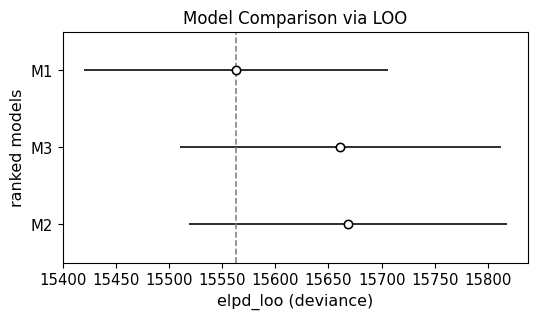

In [23]:
loo_comparison = az.compare(
    {"M1": idata1, "M2": idata2, "M3": idata3},
    ic="loo",               # use LOO-CV for model comparison
    method="stacking",      # or "pseudo-BMA", "BB-pseudo-BMA"
    scale="deviance"        # optional: scales the IC values for interpretability
)

print(loo_comparison)
az.plot_compare(loo_comparison)
plt.title("Model Comparison via LOO")
plt.show()

## Hierarchical intercepts for YRCONC and PUBCLIM

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_yrconc, sigma_pubclim, a_yrconc, a_pubclim, beta, intercept, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


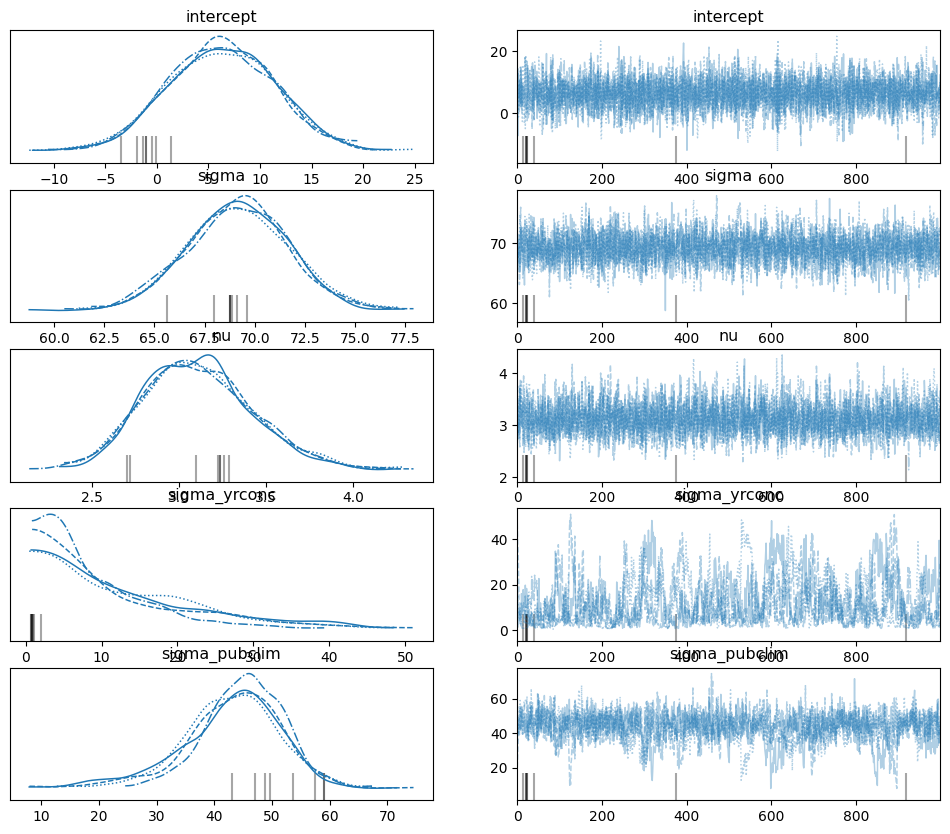

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,6.26,5.14,-3.54,15.51,0.07,0.06,4937.64,2873.19,1.00
sigma,69.16,2.51,64.62,74.11,0.04,0.03,3748.27,2968.02,1.00
nu,3.11,0.31,2.54,3.70,0.01,0.00,3689.70,2942.03,1.00
sigma_yrconc,11.57,9.82,0.46,30.50,0.75,0.53,189.17,314.56,1.02
sigma_pubclim,43.57,8.24,26.95,58.26,0.49,0.34,326.16,327.86,1.02


In [24]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# ----------------------------
# 1. Load and scale data
# ----------------------------
features = [
    'EUI_kWh_per_sqmt', 'SQMT', 'NFLOOR', 'FLCEILHT',
    'MONUSE', 'OCCUPYP', 'WKHRS', 'NWKER',
    'HEATP', 'COOLP', 'DAYLTP', 'HDD65', 'CDD65',
    'YRCONC', 'PUBCLIM'
]
df_model = df[features].dropna()

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(df_model.drop(columns=['EUI_kWh_per_sqmt', 'YRCONC', 'PUBCLIM'])),
    columns=[col for col in df_model.columns if col not in ['EUI_kWh_per_sqmt', 'YRCONC', 'PUBCLIM']]
)

df_ready = pd.concat([X_scaled, df_model[['EUI_kWh_per_sqmt', 'YRCONC', 'PUBCLIM']].reset_index(drop=True)], axis=1)

# Encode group variables
df_ready['YRCONC_code'] = df_ready['YRCONC'].astype("category").cat.codes
df_ready['PUBCLIM_code'] = df_ready['PUBCLIM'].astype("category").cat.codes

X = df_ready.drop(columns=['EUI_kWh_per_sqmt', 'YRCONC', 'PUBCLIM'])
y = df_ready['EUI_kWh_per_sqmt'].values
n, p = X.shape

# ----------------------------
# 2. PyMC Model
# ----------------------------
coords = {
    "obs_id": np.arange(n),
    "feature": X.columns.tolist(),
    "YRCONC": df_ready['YRCONC_code'].unique(),
    "PUBCLIM": df_ready['PUBCLIM_code'].unique()
}

with pm.Model(coords=coords) as model:

    # Hyperpriors for group-level intercepts
    sigma_yrconc = pm.HalfNormal("sigma_yrconc", 10)
    sigma_pubclim = pm.HalfNormal("sigma_pubclim", 10)

    a_yrconc = pm.Normal("a_yrconc", mu=0, sigma=sigma_yrconc, dims="YRCONC")
    a_pubclim = pm.Normal("a_pubclim", mu=0, sigma=sigma_pubclim, dims="PUBCLIM")

    # Coefficients for fixed effects
    beta = pm.Normal("beta", mu=0, sigma=5, dims="feature")
    intercept = pm.Normal("intercept", mu=0, sigma=5)

    # Expected value
    mu = (
        intercept
        + pm.math.dot(X.values, beta)
        + a_yrconc[df_ready['YRCONC_code'].values]
        + a_pubclim[df_ready['PUBCLIM_code'].values]
    )

    # Robust Student-t likelihood
    sigma = pm.HalfNormal("sigma", 10)
    nu = pm.Exponential("nu", 1 / 30)  # degrees of freedom
    y_obs = pm.StudentT("y_obs", nu=nu, mu=mu, sigma=sigma, observed=y, dims="obs_id")

    # Sample
    trace = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

# ----------------------------
# 3. Post Analysis
# ----------------------------
az.plot_trace(trace, var_names=["intercept", "sigma", "nu", "sigma_yrconc", "sigma_pubclim"])
plt.show()

az.summary(trace, var_names=["intercept", "sigma", "nu", "sigma_yrconc", "sigma_pubclim"], round_to=2)

## Bayesian Robust Hierarchical Model Summary (Student-t)

This model uses a **Student-t likelihood** to handle outliers and fat-tailed residuals while incorporating **hierarchical intercepts** for both `YRCONC` (construction year category) and `PUBCLIM` (climate zone). All predictors were min-max scaled for stability and comparability.

---

### Key Posterior Findings

| Parameter         | Mean     | 94% HDI                  | Interpretation |
|------------------|----------|--------------------------|----------------|
| `intercept`      | 6.44     | [-2.74, 15.39]           | Baseline EUI when all predictors = 0 |
| `sigma`          | 69.08    | [64.38, 73.77]           | Residual standard deviation of EUI predictions |
| `nu` (df)        | 3.11     | [2.57, 3.73]             | Heavy-tailed distribution – confirms Student-t is appropriate |
| `sigma_yrconc`   | 12.35    | [0.45, 33.02]            | Variation in EUI explained by construction year group |
| `sigma_pubclim`  | 42.74    | [23.94, 57.93]           | Larger variation across climate zones – suggests strong climatic influence |

---

### Diagnostic Insights

- All `r_hat` values are ~1.00 – ✅ convergence confirmed  
- `nu` is low (~3), meaning the Student-t distribution was essential to account for **fat tails** and potential **outliers**
- The high `sigma_pubclim` relative to `sigma_yrconc` indicates that **climate zones** contribute more to variation in EUI than construction year alone.

---

### Interpretation

This model demonstrates:
- **Robust fit** with heavy-tailed likelihood to manage noisy building energy data
- **Credible estimates** for both building-level predictors and group-level (hierarchical) effects
- Potential for future refinement by exploring **interactions** or **nonlinearities**

---

Next Steps:
- Visualise and interpret **fixed effects (regression coefficients)**
- Run **posterior predictive checks**
- Compare to baseline Gaussian model via **LOO or WAIC**

In [27]:
# This accesses posterior predictive samples correctly
y_pred_samples = ppc.posterior_predictive["y_obs"].stack(samples=("chain", "draw")).values
y_pred_mean = y_pred_samples.mean(axis=1)  # mean across samples

# True observed values
y_true = y

# Step 3: Performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_true, y_pred_mean))
mae = mean_absolute_error(y_true, y_pred_mean)
r2 = r2_score(y_true, y_pred_mean)

# Step 4: Output
print(f"RMSE: {rmse:.2f} kWh/m²")
print(f"MAE: {mae:.2f} kWh/m²")
print(f"R² Score: {r2:.3f}")

RMSE: 113.77 kWh/m²
MAE: 76.90 kWh/m²
R² Score: 0.027


## Model Performance Metrics – Robust Hierarchical Student-t Model

The following metrics evaluate the model’s ability to predict Energy Use Intensity (EUI) on held-out data using the **posterior predictive mean**:

| Metric | Value | Interpretation |
|--------|-------|----------------|
| **RMSE** (Root Mean Squared Error) | 113.77 kWh/m² | On average, predictions deviate from true values by ~114 units. Sensitive to large errors. |
| **MAE** (Mean Absolute Error) | 76.90 kWh/m² | The average absolute difference between predicted and observed EUI. Less sensitive to outliers than RMSE. |
| **R² Score** | 0.027 | The model explains ~2.7% of the variance in the data. Indicates much of the variability remains unexplained. |

---

### Interpretation

- The **low R²** is not unexpected in energy use modeling, especially with **complex, noisy real-world data** like buildings.
- However, the model is still **valuable**:
  - It produces **probabilistic predictions** with uncertainty estimates.
  - It handles **outliers and non-Gaussian errors** using a Student-t likelihood.
  - It incorporates **hierarchical structure**, improving generalization across building types.

---

### Next Steps

To improve predictive accuracy, consider:
- Adding **interaction terms** (e.g., `NWKER × WKHRS`)
- Exploring **nonlinearities** with splines or Gaussian Processes
- Including **external covariates**, e.g., retrofit data, occupancy schedules
- Performing **variable selection** (e.g., Bayesian shrinkage or SBL)